## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [2]:
# The parameter names must match the pipeline step names, e.g., 'classifier__max_depth'
# TODO: Define base models (Decision Tree, kNN, Logistic Regression)

# --- Define Parameter Grids ---
# Note: 'feature_selection__k' is a placeholder. It will be adjusted dynamically
# based on the number of features in each dataset later in the script.

param_grid_dt = {
    'feature_selection__k': [5, 10, 'all'],
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

param_grid_knn = {
    'feature_selection__k': [5, 10, 'all'],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

param_grid_lr = {
    'feature_selection__k': [5, 10, 'all'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # 'liblinear' works well with l1 and l2
}


# Create a list of (classifier, param_grid, name) tuples
classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, 'Decision Tree'),
    (KNeighborsClassifier(), param_grid_knn, 'k-Nearest Neighbors'),
    (LogisticRegression(random_state=42, max_iter=1000), param_grid_lr, 'Logistic Regression')
]

## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### Wine Quality Dataset

In [3]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

## Part 4: Manual Grid Search Implementation

In [4]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # 1. Adjust the feature selection parameter grid
        current_param_grid = param_grid.copy()
        k_values = [k if k != 'all' else n_features for k in current_param_grid['feature_selection__k']]
        current_param_grid['feature_selection__k'] = [k for k in k_values if k <= n_features]

        # 2. Generate all combinations of hyperparameters
        keys, values = zip(*current_param_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
        print(f"Total combinations to test: {len(param_combinations)}")

        # 3. For each parameter combination, perform cross-validation
        for params in param_combinations:
            fold_scores = []

            # a. & b. Perform 5-fold StratifiedKFold
            for train_idx, val_idx in cv.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

                # ii. Build a pipeline (with VarianceThreshold)
                pipeline = Pipeline(steps=[
                    ('variance_selector', VarianceThreshold()),
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance)
                ])

                # iii. Set the parameters
                pipeline.set_params(**params)

                # iv. Fit the pipeline
                pipeline.fit(X_train_fold, y_train_fold)

                # v. Predict probabilities
                y_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]

                # vi. Compute AUC score
                fold_scores.append(roc_auc_score(y_val_fold, y_pred_proba))

            # c. Compute the mean AUC
            mean_auc = np.mean(fold_scores)

            # d. Track the best combination
            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params

        # Create the final pipeline for this classifier
        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        final_pipeline = Pipeline(steps=[
            ('variance_selector', VarianceThreshold()),
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Set the best parameters found
        final_pipeline.set_params(**best_params)

        # Fit the final pipeline on the full training data
        final_pipeline.fit(X_train, y_train)

        # Store the fully trained best pipeline
        best_estimators[name] = final_pipeline

    return best_estimators

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.

**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring

In [5]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # Adjust feature selection parameter grid based on dataset size
        current_param_grid = param_grid.copy()
        k_values = [k if k != 'all' else n_features for k in current_param_grid['feature_selection__k']]
        current_param_grid['feature_selection__k'] = [k for k in k_values if k <= n_features]

        # Create a pipeline (with VarianceThreshold)
        pipeline = Pipeline(steps=[
            ('variance_selector', VarianceThreshold()),
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Set up StratifiedKFold cross-validation
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Run GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=current_param_grid,
            scoring='roc_auc',
            cv=cv_splitter,
            n_jobs=-1,  # Use all available CPU cores
            verbose=1
        )

        # Fit grid search on training data
        grid_search.fit(X_train, y_train)

        # Save results
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin

## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.

In [6]:
def evaluate_models(X_train, y_train, X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation (using soft voting with probabilities)
        all_probas = []
        for name, model in best_estimators.items():
            all_probas.append(model.predict_proba(X_test)[:, 1])

        # Average the probabilities
        y_pred_proba_avg = np.mean(all_probas, axis=0)
        y_pred_votes = (y_pred_proba_avg > 0.5).astype(int)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')

        # Fit the voting classifier on the training data
        voting_clf.fit(X_train, y_train)

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.

In [7]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    evaluate_models(X_train, y_train, X_test, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    evaluate_models(X_train, y_train, X_test, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!


################################################################################
PROCESSING DATASET: WINE QUALITY
################################################################################
Wine Quality dataset loaded and preprocessed successfully.
Training set shape: (1119, 11)
Testing set shape: (480, 11)
------------------------------

RUNNING MANUAL GRID SEARCH FOR WINE QUALITY
--- Manual Grid Search for Decision Tree ---
Total combinations to test: 72
------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'feature_selection__k': 5, 'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'classifier__criterion': 'gini'}
Best cross-validation AUC: 0.7832
--- Manual Grid Search for k-Nearest Neighbors ---
Total combinations to test: 48
------------------------------------------------------------------------------------------
Best parameters for k-Nearest Neighbors: {'feature_selection__k': 5, 'class

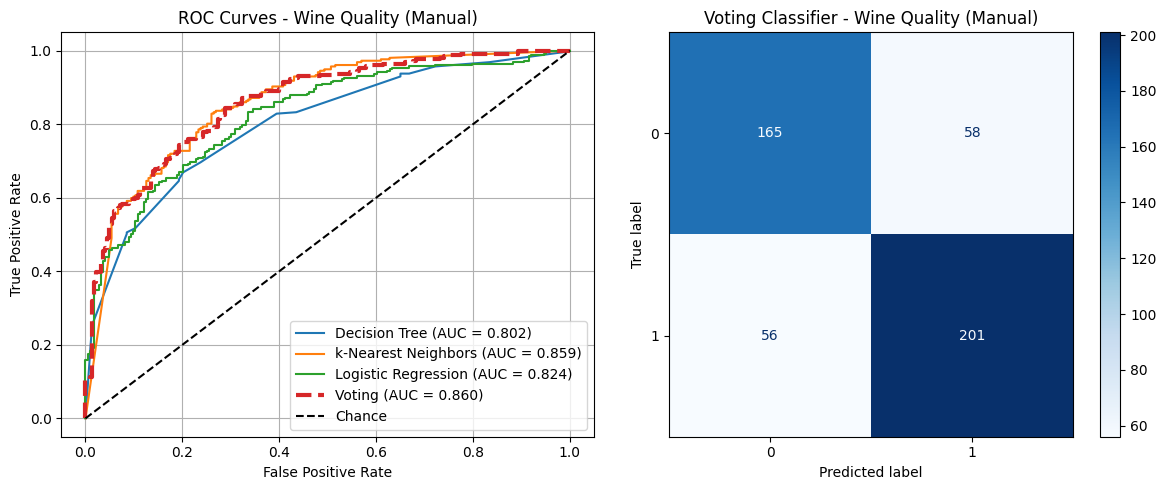


RUNNING BUILT-IN GRID SEARCH FOR WINE QUALITY

--- GridSearchCV for Decision Tree ---
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params for Decision Tree: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'feature_selection__k': 5}
Best CV score: 0.7832

--- GridSearchCV for k-Nearest Neighbors ---
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params for k-Nearest Neighbors: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance', 'feature_selection__k': 5}
Best CV score: 0.8667

--- GridSearchCV for Logistic Regression ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'feature_selection__k': 11}
Best CV score: 0.8052

EVALUATING BUILT-IN MODELS FOR WINE QUALITY

--- Individual Model Performance ---

Decision Tree:

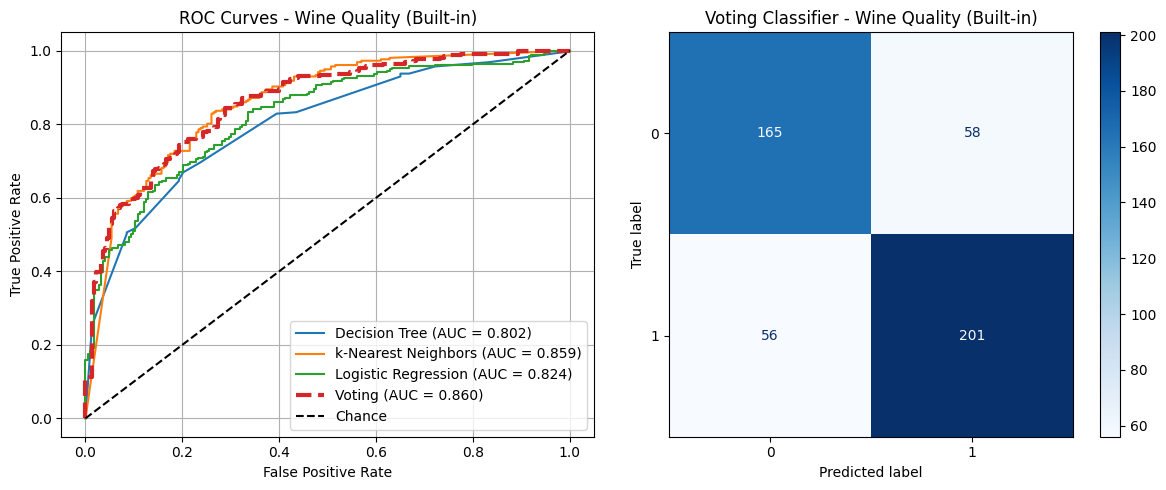


Completed processing for Wine Quality

WINE QUALITY DATASET PROCESSED!


In [8]:
# --- Run Pipeline for Wine Quality Dataset ---
try:
    run_complete_pipeline(load_wine_quality, "Wine Quality")
except Exception as e:
    print(f"An error occurred while processing Wine Quality: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*80)
print("WINE QUALITY DATASET PROCESSED!")
print("="*80)